In [53]:
suppressWarnings(suppressMessages(library(Biostrings)))
library(ggplot2)
library(reshape2)
library(RColorBrewer)
library(plyr)
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(scales)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
fills = c('A'='#ffd92f', 'C'='#4daf4a', 'G'='#e41a1c', 'U'='#377eb8', 'A:U'='#93da69', 'U:A'='#93da69', 'G:C'='#c1764a', 'C:G'='#c1764a', 'G:U'='#b26cbd', 'U:G'='#b26cbd', "A:C"='gray30', 'C:A'='gray30', 'A:G'='gray30', 'G:A'='gray30', 'C:U'='gray30', 'U:C'='gray30', 'A:A'='gray30', 'C:C'='gray30', 'G:G'='gray30', 'U:U'='gray30', 'A:-'='gray30', '-:A'='gray30', 'C:-'='gray30', '-:C'='gray30', 'G:-'='gray30', '-:G'='gray30', 'U:-'='gray30', '-:U'='gray30', '-'='gray60', '-:-'='gray60', 'N'='gray60', 'N:N'='gray60')

In [2]:
load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('isotype-specific.RData')
load('consensus-IDEs.RData')
load('clade-isotype-specific-freqs.RData')
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
genome_table = read.delim('genome_table+.txt', sep='\t', stringsAsFactors=FALSE, header=FALSE, col.names=c("species_short", "species", "species_long", "domain", "clade"))

# Weird tRNAs in context of sequence features

List of weird tRNAs:

- Susan Ackerman's [Arg-UCU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Arg-TCT-4-1.html) in mouse. 
    - Only Arg-UCU without an intron.
    - See alignment for details, but it also includes C20a instead of T20a, G20b, C40 instead of T40, etc. 
    - Most importantly, it contains C50, but its mutation to T50 likely causes misfolding in the B6J mouse strain.
    - Conserved in human, and potentially all the way to zebrafish and Drosophila.
- [Lys-CUU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/genes/tRNA-Lys-CTT-1-1.html) in yeast. It's the only isodecoder for Lys-CUU. Can fold into an "F"-form able to be imported into the mitochondria.
- [Gly-GCC](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Gly-GCC-2-1.html), which is downregulated in B cell lymphoma cell lines (Maute paper). Represses RPA1, which is involved in DNA repair, DNA replication, and DNA damage response. Overexpression reduces proliferation and sensitizes cell to etoposide-induced DNA damage.

## Code for extracting position-specific scores

We need to (a) filter for the subset of tRNAs we're interested in, (b) create a multiple alignment -> covariance model (no need to calibrate), (c) align, (d) parse output, and (e) visualize.

In [78]:
calculate_position_specific_scores = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {
  # get subset of tRNAs and write to file
  subset = identities %>% select_('species', 'seqname', 'isotype', 'clade', 'anticodon', 'quality') %>% filter_('quality')
  if (clade != "") subset = subset %>% filter_(paste0("clade == '", clade, "'"))
  if (isotype != "") subset = subset %>% filter_(paste0("isotype == '", isotype, "'"))
  if (isotype != "" & anticodon != "") subset = subset %>% filter_(paste0("anticodon == '", anticodon, "'"))
  if (dim(subset)[1] < 5) return('Rare anticodon; could not generate consensus')
  euk_seqs = readDNAStringSet(filepath = '/projects/lowelab/users/blin/identity/euk-isotypes/euk-tRNAs.fa', format = 'fasta')
  names(euk_seqs) = str_replace(str_extract(names(euk_seqs), '\\S+'), '\\|', '_')
  writeXStringSet(euk_seqs[match(subset$seqname, names(euk_seqs))], filepath = 'subset.fa')

  # create covariance model
  system('cmalign -g --notrunc --matchonly -o subset.sto /projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm subset.fa > /dev/null')
  system('cmbuild --hand --enone -F subset.cm subset.sto > /dev/null')

  # remove intron from our tRNA
  #   align our tRNA to the numbering model
  seq = DNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, "-raw.fa"))
  system(paste('cmalign -g --notrunc --matchonly -o', paste0(seqname, "-raw.sto"), '/projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm', paste0(seqname, "-raw.fa"), " > /dev/null"))
  
  #  rewrite tRNA to file and realign to subset model
  seq = str_replace_all(str_extract(as.character(read.delim(paste0(seqname, '-raw.sto'))[2, ]), '[AGCU-]+$'), '-', '')
  seq = RNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, ".fa"))
  system(paste0('cmalign -g --notrunc --matchonly --tfile ', seqname, '.tfile -o ', seqname, '.sto subset.cm ', seqname, '.fa > /dev/null'))
    
  # parse output
  system(paste0('python parse-parsetree.py ', seqname, '.tfile > ', seqname, '.bits'))
  bits = read.table(paste0(seqname, '.bits'), header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Input") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position))

  # emit and read in consensus sequence
  # replace lowercase (low probability, generally V-loop/CCA) residues from consensus with Ns. In practice, tRNA aligns properly still.
  system('cmemit -c subset.cm | perl -npe "if(/^[acguACGU]/){s/[agcu]/N/g}" > subset-cons.fa')
  system('cmalign -g --notrunc --matchonly --tfile subset-cons.tfile -o subset-cons.sto subset.cm subset-cons.fa > /dev/null')
  system('python parse-parsetree.py subset-cons.tfile > subset-cons.bits')

  bits = rbind(bits, read.table('subset-cons.bits', header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Consensus") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position)))

  # compare consensus and our tRNA fix instances where cmemit did not output most likely identity
  bits = bits %>% group_by(Position) %>%
    arrange(Source) %>% 
    summarize(Bits = Bits[2] - Bits[1], Consensus = Identity[1], Identity = Identity[2]) %>% 
    ungroup() %>%
    # if tRNA scores higher than subset consensus, replace it
    mutate(Consensus = ifelse(Bits > 0 & as.character(Identity) != as.character(Consensus),
                              str_replace_all(as.character(Identity), "[AGCU]", "N"),
                              as.character(Consensus))) %>%
    mutate(Bits = ifelse(Bits > 0, 0, Bits))

  # clean up
#   system('rm subset.sto subset.cm subset.fa')
#   system('rm subset-cons.fa subset-cons.bits subset-cons.tfile subset-cons.sto')
#   system(paste0('rm ', seqname, '.fa ', seqname, '-raw.fa ', seqname, '.bits ', seqname, '.sto ', seqname, '-raw.sto ', seqname, '.tfile')) 

  return(bits)
}
    
calculate_scores_multiplex = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {

  bits = calculate_position_specific_scores(seq, seqname, clade = "", isotype = "", anticodon = "") %>% 
    mutate(Clade = "Eukaryota", Isotype = "All isotypes", Anticodon = "")

  if (clade != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype = "", anticodon = "") %>%
                 mutate(Clade = clade, Isotype = "All isotypes", Anticodon = ""))
  }
  if (isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype, anticodon = "") %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (clade != "" & isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = clade, isotype = isotype, anticodon = "") %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype = isotype, anticodon = anticodon) %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = anticodon))
  }
  if (clade != "" & isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype, anticodon) %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon))
  }
  
  return(bits %>% mutate(tRNA = seqname))
}
    
calculate_scores_multiseq = function(seqs = "", clade = "Eukaryota", isotype = "", anticodon = "") {  
  multi_bits = data.frame(Position = character(0), Bits = character(0), Identity = character(0), Consensus = character(0), Clade = character(0), Isotype = character(0), Anticodon = character(0))
  for (i in 1:length(seqs)) {
    bits = calculate_position_specific_scores(seqs[i], names(seqs)[i], clade, isotype, anticodon)
    if (typeof(bits) == "character" && bits == 'Rare anticodon; could not generate consensus') next
    bits = bits %>% mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon, tRNA = names(seqs)[i])
    multi_bits = rbind(multi_bits, bits)
  }
  
  return(multi_bits)
}

# Arg-UCU

First, let's look at how well this tRNA matches the consensus for different clades and isotypes:

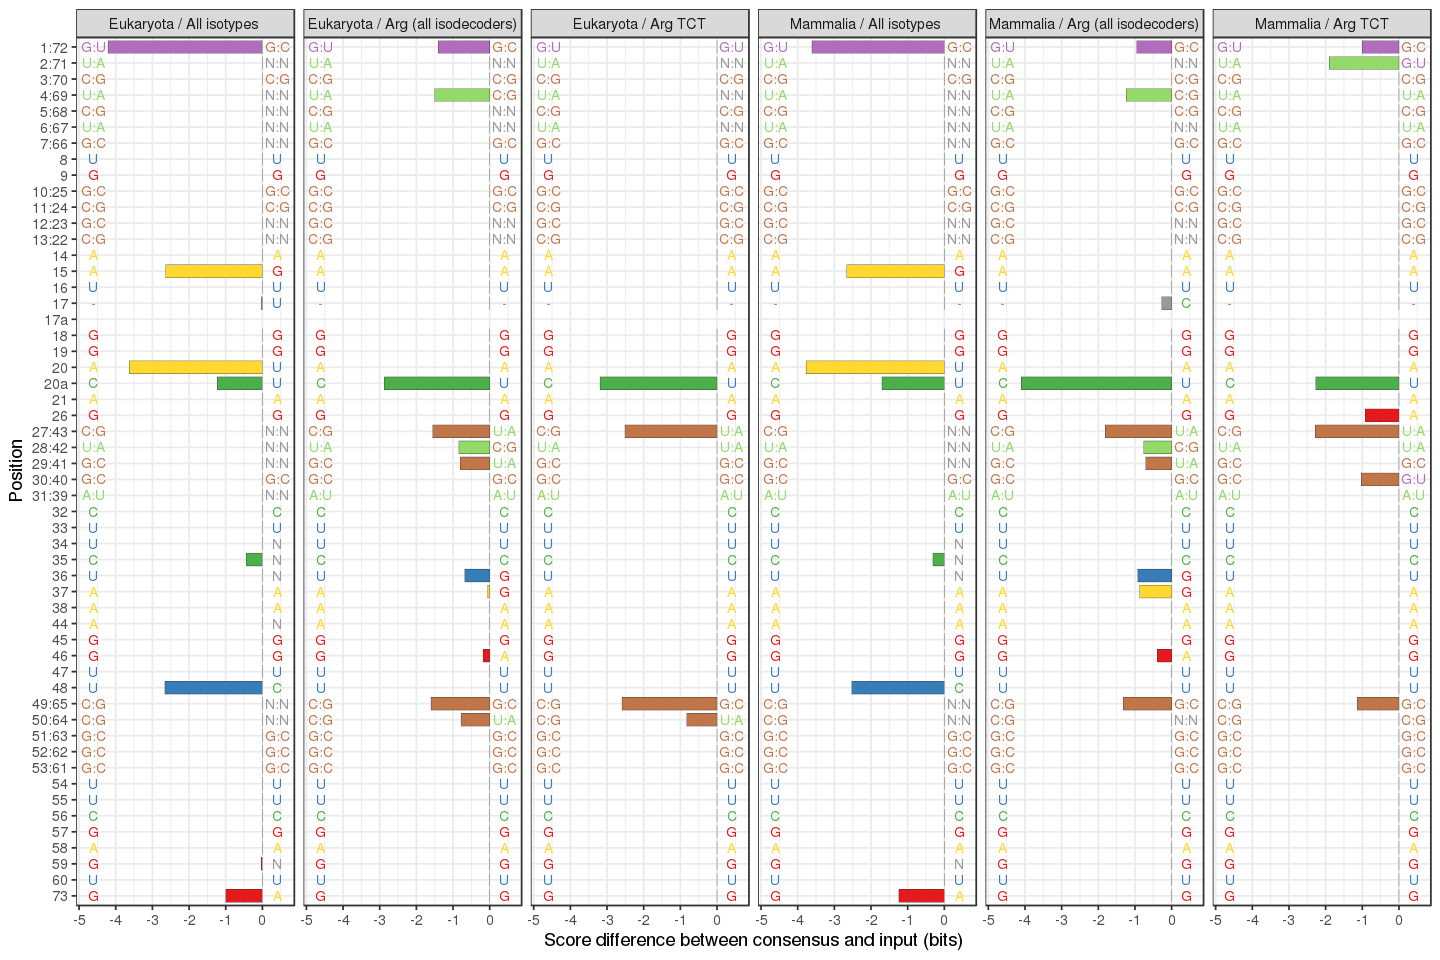

In [79]:
options(repr.plot.width=12, repr.plot.height=8)
bits = calculate_scores_multiplex(seq = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                  seqname = "hg19_chr1.trna84-ArgTCT",
                                  clade = "Mammalia", 
                                  isotype = "Arg",
                                  anticodon = "TCT")

df = bits %>% mutate(Clade = as.factor(Clade), Isotype = as.factor(Isotype), Anticodon = as.factor(Anticodon), Consensus = as.factor(Consensus), Identity = as.factor(Identity), tRNA = as.factor(tRNA)) %>%
  mutate(Isodecoder = as.factor(paste0(Isotype, " ", Anticodon))) %>%
  select(Position, Clade, tRNA, Bits, Consensus, Identity, Isodecoder)

ggplot(df) + geom_bar(aes(x = Position, y = Bits, fill = Identity), size = 0.1, color = 'gray20', width = 0.8, position = 'dodge', stat = 'identity') + 
  facet_wrap( ~ paste0(Clade, " / ", Isodecoder), nrow = 1) + 
  geom_text(aes(x = Position, color = Identity, label = Identity), size = 3, y = min(df$Bits) - 0.4) +
  geom_text(aes(x = Position, color = Consensus, label = Consensus), size = 3, y = max(df$Bits) + 0.4) +
  coord_flip() +
  scale_fill_manual(values=fills) +
  scale_color_manual(values=fills) + 
  scale_x_discrete(limits = rev(levels(df$Position))) + 
  scale_y_continuous(limits = c(min(df$Bits) - 0.6, max(df$Bits) + 0.6)) + 
  theme(legend.position='none') + 
  ylab("Score difference between consensus and input (bits)")

What sequence features are penalized, and how far back evolutionarily does it go?

- C20a is universally weird
- C27:G43 at 27:43

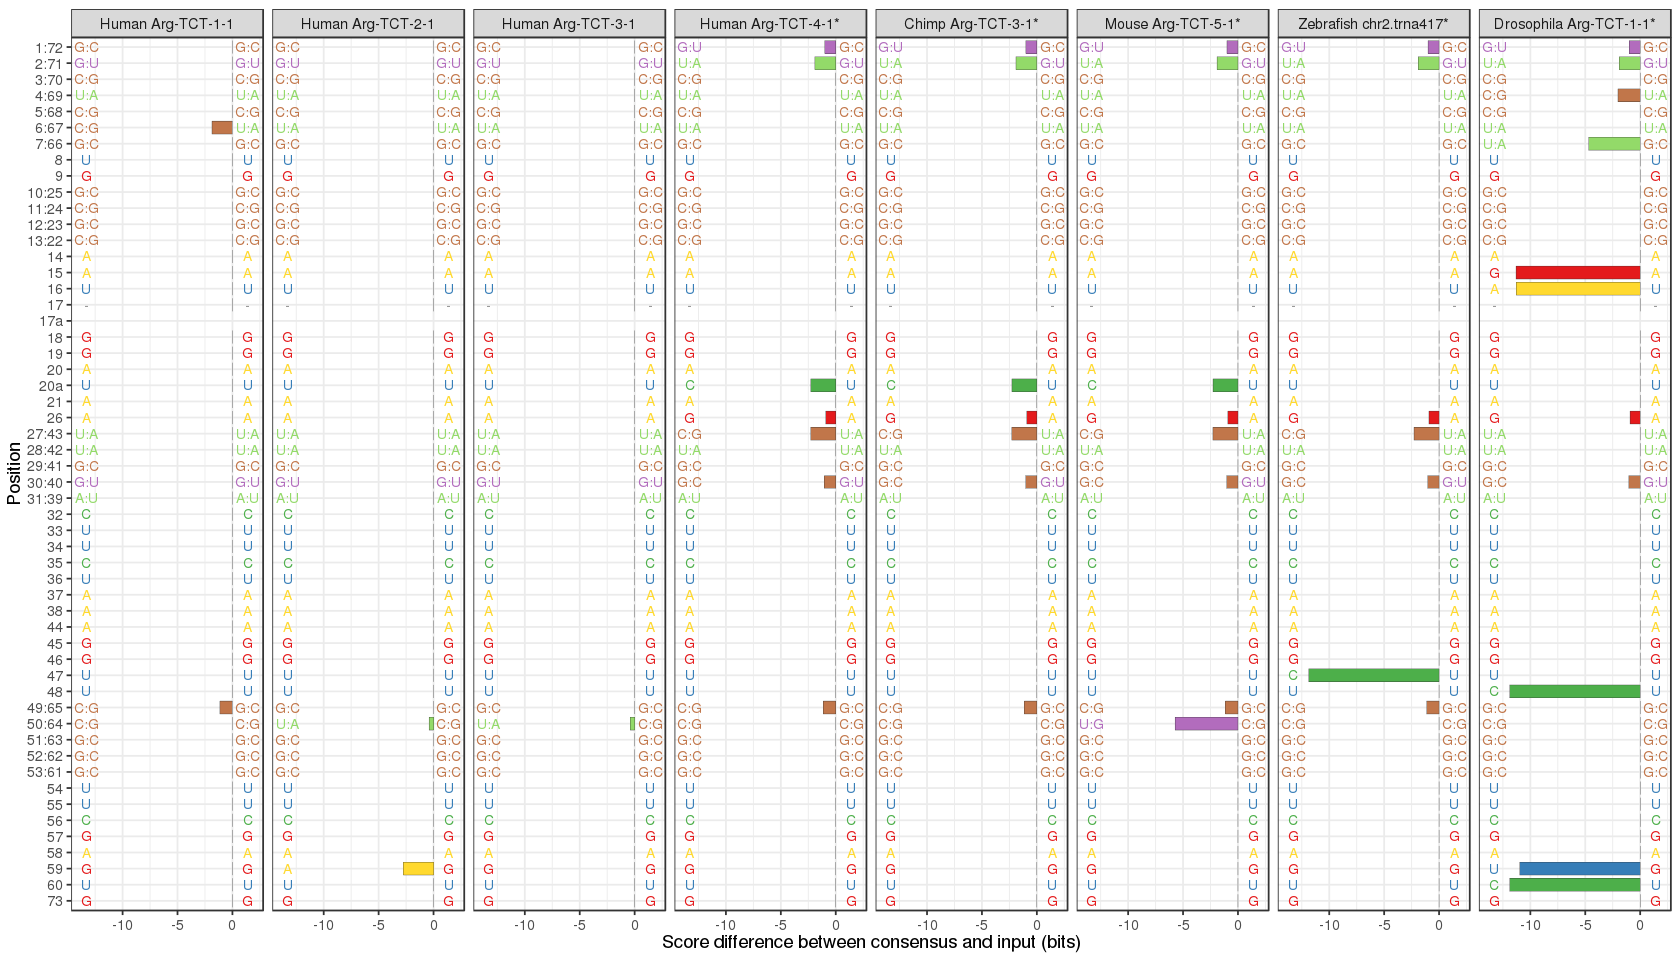

In [83]:
options(repr.plot.width=14, repr.plot.height=8)
bits = calculate_scores_multiseq(seqs = c("Human-Arg-TCT-4-1-B" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Human-Arg-TCT-1-1" = "GGCTCCGTGGCGCAATGGAtAGCGCATTGGACTTCTAgaggctgaaggcATTCAAAGGtTCCGGGTTCGAGTCCCGGCGGAGTCG",
                                          "Human-Arg-TCT-2-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgtgacgaatagagcaATTCAAAGGtTGTGGGTTCGAATCCCACCAGAGTCG",
                                          "Human-Arg-TCT-3-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgctgagcctagtgtggtcATTCAAAGGtTGTGGGTTCGAGTCCCACCAGAGTCG",
                                          "Chimp-Arg-TCT-3-1-B" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Mouse-Arg-TCT-5-1-B" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCTGGGTTCGAGTCCCGGCAGAGATG",
                                          "Zebrafish-chr2.trna417-ArgTCT-B" = "GTCTCTGTGGCGCAATGGAatAGCGCGCTGGACTTCTAATCCAGAGGcTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Drosophila-tRNA-Arg-TCT-1-1-B" = "GTCCCTTTGGCGCAGAGGAtAGCGCGTTGGACTTCTAATCCAAAGGtCGCGGGTTCGATCCCCGCAAGGGATG"),
                                 clade = "Mammalia", isotype = "Arg", anticodon = "TCT")

bits %>% select(Position, Bits, Identity, Consensus, tRNA) %>%
  mutate(tRNA = revalue(tRNA, c("Human-Arg-TCT-1-1" = "Human Arg-TCT-1-1", "Human-Arg-TCT-2-1" = "Human Arg-TCT-2-1", "Human-Arg-TCT-3-1" = "Human Arg-TCT-3-1", "Human-Arg-TCT-4-1-B" = "Human Arg-TCT-4-1*", "Chimp-Arg-TCT-3-1-B" = "Chimp Arg-TCT-3-1*", "Mouse-Arg-TCT-5-1-B" = "Mouse Arg-TCT-5-1*", "Zebrafish-chr2.trna417-ArgTCT-B" = "Zebrafish chr2.trna417*", "Drosophila-tRNA-Arg-TCT-1-1-B" = "Drosophila Arg-TCT-1-1*"))) %>%
  mutate(tRNA = factor(tRNA, levels = c("Human Arg-TCT-1-1", "Human Arg-TCT-2-1", "Human Arg-TCT-3-1", "Human Arg-TCT-4-1*", "Chimp Arg-TCT-3-1*", "Mouse Arg-TCT-5-1*", "Zebrafish chr2.trna417*", "Drosophila Arg-TCT-1-1*"))) %>%
  ggplot() + geom_bar(aes(x = Position, y = Bits, fill = Identity), size = 0.1, color = 'gray20', width = 0.8, position = 'dodge', stat = 'identity') + 
    facet_wrap( ~ tRNA, nrow = 1) +
    geom_text(aes(x = Position, color = Identity, label = Identity), size = 3, y = min(bits$Bits) - 1.4) +
    geom_text(aes(x = Position, color = Consensus, label = Consensus), size = 3, y = max(bits$Bits) + 1.4) +
    coord_flip() +
    scale_fill_manual(values=fills) +
    scale_color_manual(values=fills) + 
    scale_x_discrete(limits = rev(levels(bits$Position))) + 
    scale_y_continuous(limits = c(min(bits$Bits) - 2, max(bits$Bits) + 2)) + 
    theme(legend.position='none') + 
    ylab("Score difference between consensus and input (bits)")

The positions that are consistently conserved through 